In [3]:
from cmp import *
% matplotlib notebook

<IPython.core.display.Javascript object>


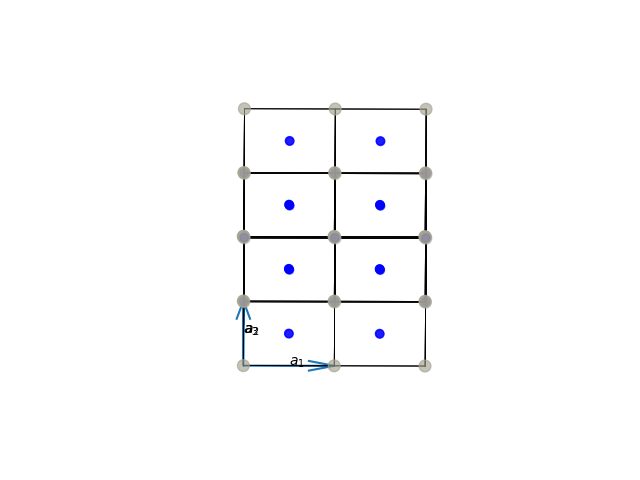

In [6]:
# Inputs

# Lattice vectors (3 vectors of length 3)
a = 1
b = 2
a1 = np.array([1, 0, 0])
a2 = np.array([0, 1, 0])
a3 = np.array([0, 0, 1])
theta = 80*np.pi/180

# Array of basis vectors
basis = np.array([[0,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5]])
# Colors for each of the basis vectors
colors = ('xkcd:cement','b','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,1,1,1)


# Gridline type:
# Hard: lines along cartesian axes at integer spacings
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "lattice"

# Limit type:
# Hard: Sets a hard limit on the plotting boundary (default  x = y = z = [0,2])
# Dynamic: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# WDynamic: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "wdynamic"
Maxs = [2,2,2]
Mins = [0,0,0]

LatticeCreator(a1,a2,a3,basis,colors,sizes,LimType,GridType,Mins,Maxs)